# Rasterizing WU data
This notebook demonstrates how to vectorize, then rasterize the weather underground data so that it can be used in the future.

You need to have an environment with GDAL installed in order for this to work.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_60771/2474553885.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
wu_temp = pd.read_csv("../data/raw/temperature/weather_underground/july23_wu_durham.csv")
print(len(wu_temp))
wu_temp.head()

126


,stationId,morn_avg,aft_avg,eve_avg
0,KNCDURHA272,22.129301,30.464151,27.943548
1,KNCDURHA486,21.491667,31.377957,27.698656
2,KNCDURHA393,21.553226,31.622849,28.851075
3,KNCDURHA409,22.403297,33.564770,29.155220
4,KNCDURHA407,22.242204,30.466935,28.387332


In [3]:
# Get stations data
stations = pd.read_csv("../data/raw/temperature/weather_underground/durham_stations.csv")
stations = stations[stations['qcStatus'] == 1]
print(len(stations))
stations.head()

181


,stationId,latitude,longitude,qcStatus
0,KNCDURHA272,35.939,-78.970,1
1,KNCDURHA309,35.940,-78.967,1
2,KNCDURHA486,35.940,-78.967,1
4,KNCDURHA393,35.943,-78.973,1
6,KNCDURHA409,35.946,-78.970,1


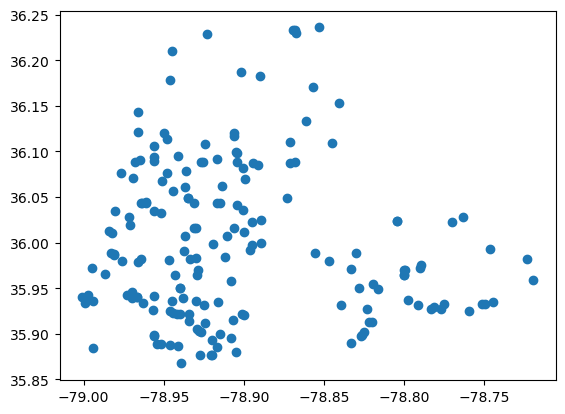

In [4]:
import matplotlib.pyplot as plt
plt.scatter(stations['longitude'], stations['latitude'])

In [5]:
station_w_temp = stations.merge(wu_temp, on='stationId', how='inner')
print(len(station_w_temp))
station_w_temp.head()

126


,stationId,latitude,longitude,qcStatus,morn_avg,aft_avg,eve_avg
0,KNCDURHA272,35.939,-78.970,1,22.129301,30.464151,27.943548
1,KNCDURHA486,35.940,-78.967,1,21.491667,31.377957,27.698656
2,KNCDURHA393,35.943,-78.973,1,21.553226,31.622849,28.851075
3,KNCDURHA409,35.946,-78.970,1,22.403297,33.564770,29.155220
4,KNCDURHA407,35.934,-78.963,1,22.242204,30.466935,28.387332


# Now, create a geopandas dataframe, that we can then save as a shapefile

In [31]:
# Create a geopandas dataframe
geometry = [Point(xy) for xy in zip(station_w_temp['longitude'], station_w_temp['latitude'])]

gdf = gpd.GeoDataFrame(station_w_temp, geometry=geometry)

In [32]:
gdf = gdf.set_crs(epsg=4326)

In [33]:
gdf = gdf[~gdf['eve_avg'].isna()]

In [34]:
# Remove latitutde,longitude, qcStatus columns
gdf = gdf.drop(['latitude', 'longitude', 'qcStatus'], axis=1)

In [35]:
# Add a column of ones
gdf['ones'] = 1

In [36]:
# Save as a shape file
gdf.to_file("../data/preprocessed/temperature/durham_stations_w_temp.shp")

In [37]:
!ogrinfo ../data/preprocessed/temperature/durham_stations_w_temp.shp durham_stations_w_temp

INFO: Open of `../data/preprocessed/temperature/durham_stations_w_temp.shp'
      using driver `ESRI Shapefile' successful.

Layer name: durham_stations_w_temp
Metadata:
  DBF_DATE_LAST_UPDATE=2024-01-22
Geometry: Point
Feature Count: 125
Extent: (-79.001000, 35.867500) - (-78.723070, 36.236000)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
stationId: String (80.0)
morn_avg: Real (24.15)
aft_avg: Real (24.15)
eve_avg: Real (24.15)
ones: Integer64 (18.0)
OGRFeature(durham_stations_w_temp):0
  stationId (String) = KN

In [38]:
gdf.to_crs(epsg=3857, inplace=True)
bounds = gdf.total_bounds
print(bounds)

[-8794351.09215941  4282404.85932497 -8763412.06608323  4333143.38731947]


In [39]:
# Add a buffer of 1000 meters
bounds = gdf.total_bounds
bounds = [bounds[0] - 1000, bounds[1] - 1000, bounds[2] + 1000, bounds[3] + 1000]

In [68]:
!gdal_rasterize -to SRC_SRS=EPSG:4326 -init 0.0 -add -a eve_avg -tap -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -of GTIFF -l durham_stations_w_temp -a_srs EPSG:3857 -tr 500 500 -ot Float64 -a_nodata -9999.0 ../data/preprocessed/temperature/durham_stations_w_temp.shp ../data/preprocessed/temperature/durham_stations_w_temp_500m.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


# Validation

In [69]:
import numpy as np
import rasterio as rio

In [70]:
with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif') as src:
    temp_data = src.read(1)

In [71]:
print(np.unique(temp_data))

[ 0.         25.275      26.77876344 26.79247312 26.8327957  26.89623656
 27.05994624 27.07768817 27.20769231 27.34919355 27.36182796 27.36370968
 27.43575269 27.47446237 27.48602151 27.52177419 27.54946237 27.55215054
 27.62564103 27.63928571 27.65134409 27.65860215 27.66693548 27.6827957
 27.68459459 27.70166667 27.7296496  27.80655271 27.81505376 27.82264151
 27.84086022 27.85430108 27.92419355 27.9772973  28.00188679 28.02069892
 28.02123656 28.04543011 28.06765499 28.1097035  28.11370968 28.1577957
 28.20564516 28.21767677 28.25366795 28.25510753 28.25876011 28.26424731
 28.26846361 28.26935484 28.27146739 28.34623656 28.36370968 28.38252688
 28.38274933 28.38733154 28.39555556 28.40887097 28.44327957 28.44516129
 28.54701087 28.5655914  28.61236559 28.63709677 28.65916667 28.69327957
 28.69623656 28.70026882 28.70994624 28.71142061 28.75537634 28.75725806
 28.75806452 28.78894879 28.80295699 28.81428571 28.82634409 28.85107527
 28.8870317  28.90509259 28.91639344 28.97115903 29.0

In [54]:
temp_data.shape

(107, 67)

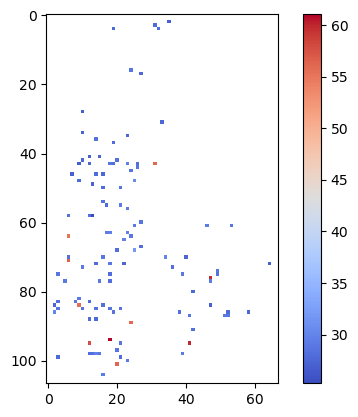

In [74]:
temp_data[temp_data == 0] = np.nan
plt.imshow(temp_data, cmap='coolwarm')
plt.colorbar()

In [75]:
np.sum(temp_data > 1)

115

Under this parameterization, we sum up values when there are multiple measurements within each cell. This is because we are avoiding writing a ton of code to do this operation for us...

We need the counts anyways, so let's extract the station count for each cell.

In [46]:
!gdal_rasterize -to SRC_SRS=EPSG:4326 -a ones -init 0 -add -tap -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -of GTIFF -l durham_stations_w_temp -a_srs EPSG:3857 -tr 500 500 -ot Float64 -a_nodata -9999.0 ../data/preprocessed/temperature/durham_stations_w_temp.shp ../data/preprocessed/temperature/durham_station_count_w_temp_500m.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [47]:
with rio.open('../data/preprocessed/temperature/durham_station_count_w_temp_500m.tif') as src:
    data = src.read(1)

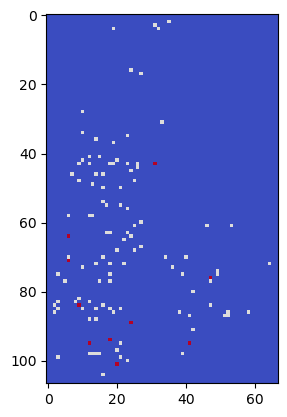

In [49]:
data[data == -9999] = np.nan
plt.imshow(data, cmap='coolwarm')

In [50]:
# Validate that the final result looks correct
print(data.sum())
data.sum() == len(gdf)

125.0

In [57]:
print(temp_data.shape)
print(temp_data.shape == data.shape)

(107, 67)
True


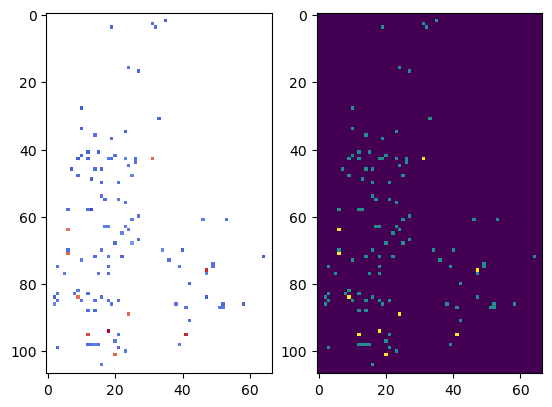

In [76]:
plt.subplot(1,2,1)
plt.imshow(temp_data, cmap='coolwarm')
plt.subplot(1,2,2)
plt.imshow(data, cmap='viridis')
plt.show()

# Averaging the final dataset
We want to divide the temperature dataset by the number of stations, so that we get the average temperature in each cell.

The code in the next cell does this, and saves the updated data for later reference.

In [79]:
# Resave the temp data as a tif
temp_data = temp_data / data
with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif') as src:

    with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif', 'w', **src.profile) as dst:
        dst.write(temp_data, 1)

In [80]:
with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif') as src:
    temp_data = src.read(1)

print(np.unique(temp_data))

[25.275      26.77876344 26.79247312 26.8327957  26.89623656 27.05994624
 27.07768817 27.20769231 27.34919355 27.36182796 27.36370968 27.43575269
 27.47446237 27.48602151 27.52177419 27.54946237 27.55215054 27.61752505
 27.62564103 27.63928571 27.65134409 27.65860215 27.66693548 27.6827957
 27.68459459 27.70166667 27.7296496  27.80655271 27.81505376 27.82110215
 27.82264151 27.84086022 27.85430108 27.92419355 27.96681532 27.97419355
 27.9772973  28.00188679 28.02069892 28.02123656 28.04543011 28.06209677
 28.06765499 28.1097035  28.11370968 28.1577957  28.20564516 28.21767677
 28.22056452 28.25366795 28.25510753 28.25876011 28.26424731 28.26846361
 28.26935484 28.27146739 28.34623656 28.36370968 28.38252688 28.38274933
 28.38733154 28.39555556 28.40887097 28.44327957 28.44516129 28.54701087
 28.5655914  28.61236559 28.63709677 28.65916667 28.69327957 28.69623656
 28.70026882 28.70994624 28.71142061 28.75537634 28.75725806 28.75806452
 28.78894879 28.80295699 28.81078629 28.81428571 28.

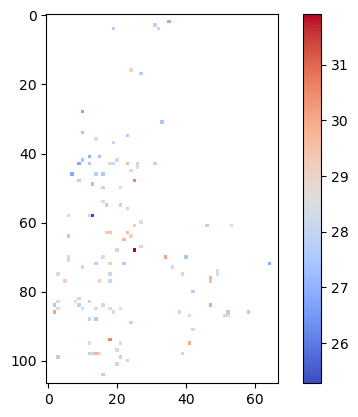

In [85]:
plt.imshow(temp_data, cmap='coolwarm')
plt.colorbar()